In [59]:
# Deterministic lot-sizing dynamic programming solution
import numpy as np
import pandas as pd
def wagner_whitin(Fixed_Cost,Production_Cost,Holding_Cost,
                  Max_Inventory,Max_Production,d,inv_start):
    big = float("inf")
    
    '''
    Fixed_Cost is the fixed cost if production happens in a period
    Production_Cost is the per unit cost of production
    Holding_Cost is the per unit cost of holding inventory
    Max_Inventory is the max inventory that can be held in a period
    Max_Production is the max production capacity in a period
    d is the vector of deterministic demands
    inv_start is the starting inventory
    '''

    K= Fixed_Cost # fixed cost of production
    c= Production_Cost # variable cost of production per unit
    h= Holding_Cost # variable cost of holding inventortory per unit

    '''
    The recursive solution involves looping backwards from the last time period.
    Hence, I add an "insignificant value" of 0 at the beginning so that the last
    demand evaluated in the recursive solution is at index t=1. This is required 
    because I evaluate the cost function at each level of inventory in each time
    period. Hence, the index in the reverse loop also serves as the column number
    for the matrix of costs that will be evaluated.
    '''
    demand = [0] + d

    n=len(demand)-1 # number of periods extracted from the demand array
    inventory0=inv_start # starting inventory
    max_inv=Max_Inventory # maximum inventory that can be held
    max_prod=Max_Production # maxmum production that can happen in a period

    '''
    The value function matrix (F) is a matrix. The matrix rows represent the time
    period (= the number of demand periods) and the columns represent the different
    values of inventory that can be held in that time period. Every period can have 
    inventory going from 0 to max_inv, hence the dimensions

    The decision matrix (x) is the most important part of the solution, which stores
    the production decision in each time period. Since there is no need to store the
    decision for the "fake" demand at t=0 position in the demand array, this matrix 
    starts with n+1

    '''
    F = np.zeros([n + 2, max_inv + 1])
    x = np.zeros([n + 1, max_inv + 1], dtype=int)


    '''
    Looping for evaluating the costs and decision starts from the last time period
    '''

    for t in range(n,0,-1) :
        '''   
        In each time period, we then evaluate over all possible inventories (subject
        to the maximum inventory that can be held)
        '''
        

        for i in range(max_inv + 1) :
            '''
            To meet the demand in this period, the min production should be
            demand (d) minus the inventory carried into the period (i)
        
            Similarly, max production in this period depends on the maximum
            production and the maximum inventory that can be held after meeting
            the demand (d - i).
            '''
  
            minProduction = max(0, demand[t] - i)
            maxProduction = min(max_prod, max_inv - i + demand[t])
        
            Current_cost = big

            for p in range(minProduction, maxProduction+1):
                '''
                p is the production that happens in this time period
                
                j is the inventory that will be carried to the next period,
                which is the inventory left after meeting demand in the current
                period (d - i) plus the production p
            
                Production cost will be c*p
                If production happens, there is a fixed cost to production (K).
                Therefore, K is added when p>0
                '''

                j = i + p - demand[t]
                ProductionCost = c*p
                if p > 0 :
                    ProductionCost += K
                    '''
                    The cost_to_move is essentially is the total cost of of 
                    producing and holding inventory j from period t to t+1. 
                    This is evaluated all levels of possible inventory 
                    (by looping over p)
            
                    If the cost_to_move is less than the current_costs, then
                    we re-evaluate our production policy to produce in the
                    current period (t) and hold for the next period t
                    '''
      
                Cost_to_move = h*j + ProductionCost + F[t+1,j]
     
                if Cost_to_move<Current_cost:
                    Current_cost = Cost_to_move
                    policy = p
            '''
            If the Cost_to_moove is indeed less than the current_cost, the value
            of F is updated. It basically means, that we produce and hold inventory
            in the current period
            
            The production policy is also updated to make production possible in the 
            current period
            '''
            F[t,i] = Current_cost
            x[t,i] = policy
            
    '''
    The final cost is stored in the first time period (row) and starting invenrory level
    (column)
    ---> F[1,inventory0]
    
    The production quantities is located in x. Again, the time period (row) 
    and starting inventory level (column) for each time period provides this infomation
    --->x[t,inventory0]
    '''
    
    Optimal_Production_Schedule = []
    Inventory_Carryover=[]
    i = inventory0
    for t in range(1,n+1) : 
        Optimal_Production_Schedule.append(x[t,i])
        i = i + x[t,i] - demand[t]
        Inventory_Carryover.append(i)
    solution_dictionary={'Production_Schedule':Optimal_Production_Schedule,
                         'Inventory_Schedule':Inventory_Carryover,
                         'Minimum Cost':F[1,inventory0]}
 
    return (solution_dictionary)


    

In [60]:
y=wagner_whitin(100,7,1,400,500,[70,90,140,150,120,130],0)
y

{'Production_Schedule': [160, 0, 140, 150, 120, 130],
 'Inventory_Schedule': [90, 0, 0, 0, 0, 0],
 'Minimum Cost': 5490.0}

In [61]:
evaluated_cost={'start inv':[],'cost':[]}
for si in range(0,400,5):
    x=wagner_whitin(100,7,1,400,500,[70,90,140,150,120,130],si)
    evaluated_cost['start inv'].append(si)
    evaluated_cost['cost'].append(x['Minimum Cost'])

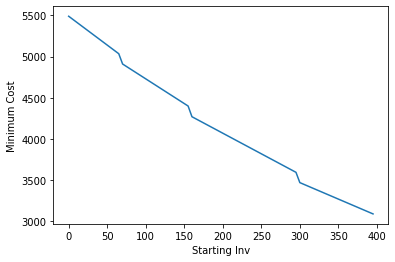

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() # make figure and axes separate objects
plt.plot(evaluated_cost['start inv'],evaluated_cost['cost'])
plt.xlabel('Starting Inv')
plt.ylabel('Minimum Cost')
plt.show()
fig.savefig('Cost vs starting inventory.jpg', 
            transparent=False, dpi=80, bbox_inches="tight")


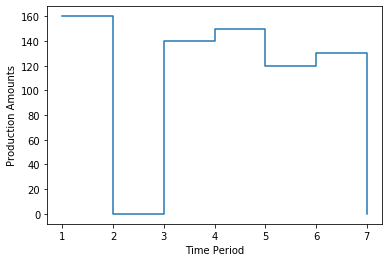

In [24]:
# Plot production policy function
import matplotlib.pyplot as plt
fig, ax = plt.subplots() # make figure and axes separate objects
plt.step(range(1,len(y['Production_Schedule'])+2),
         y['Production_Schedule']+[0],where='post')
plt.xlabel('Time Period')
plt.ylabel('Production Amounts')
plt.show()
fig.savefig('Production Policy.jpg', 
            transparent=False, dpi=80, bbox_inches="tight")


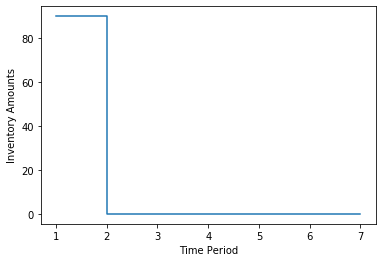

In [25]:
# Plot inventory policy function
import matplotlib.pyplot as plt
fig, ax = plt.subplots() # make figure and axes separate objects
plt.step(range(1,len(y['Inventory_Schedule'])+2),y['Inventory_Schedule']+[0],where='post')
plt.xlabel('Time Period')
plt.ylabel('Inventory Amounts')
plt.show() 
fig.savefig('Inventory Policy.jpg', 
            transparent=False, dpi=80, bbox_inches="tight")


In [26]:
# Plot the cost as a function of holding costs
comparative_stats={'holding cost':[],'cost':[]}
for hc in np.linspace(0,1,100):
    z=wagner_whitin(100,7,hc,400,500,[70,90,140,150,120,130],0)
    comparative_stats['holding cost'].append(hc)
    comparative_stats['cost'].append(z['Minimum Cost'])

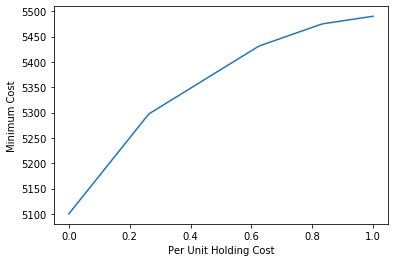

In [29]:
fig, ax = plt.subplots() # make figure and axes separate objects
plt.plot(comparative_stats['holding cost'],comparative_stats['cost'])
plt.xlabel('Per Unit Holding Cost')
plt.ylabel('Minimum Cost')
plt.show()
fig.savefig('Total cost vs per unit holding cost.jpg', 
            transparent=False, dpi=80, bbox_inches="tight")
